In [3]:
import math
import time
import itertools
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.stats import pearsonr
import trimesh
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 110

# ---- 全局常量 -------------------------------------------------
k_max        = 256      # 所有网格统一保留最多 256 个本征对
bend_isometry = False   # True → 用刚性旋转测试等距不变性

# ---- 全局缓存 -------------------------------------------------
SPEC = {}      # key ➜ (ev, eV)


def get_spectrum(L, M, k_req, key):
    """
    返回最多 k_req 个正本征，自动包含并剔除零模式；
    若可用本征 < k_req，则退到所有可用本征。
    """
    if key in SPEC:
        return SPEC[key]

    k_ask = min(k_req + 5, L.shape[0] - 1)
    ev_all, eV_all = spla.eigsh(
        L, k=k_ask, M=M,
        which="SA", tol=1e-8
    )

    eps_thresh = 1e-12
    mask = (ev_all > eps_thresh) & np.isfinite(ev_all)
    ev_pos, eV_pos = ev_all[mask], eV_all[:,mask]

    if ev_pos.size < 2:
        raise RuntimeError(f"仅检测到 {ev_pos.size} 个正特征，不足 2 个，无法继续。")

    k_use = min(k_req, ev_pos.size)
    ev, eV = ev_pos[:k_use], eV_pos[:,:k_use]

    SPEC[key] = (ev, eV)
    return ev, eV


def make_torus(R=2.0, r=0.7, nu=60, nv=30):
    u = np.linspace(0, 2*np.pi, nu, endpoint=False)
    v = np.linspace(0, 2*np.pi, nv, endpoint=False)
    uu, vv = np.meshgrid(u, v, indexing="ij")
    x = (R + r*np.cos(vv))*np.cos(uu)
    y = (R + r*np.cos(vv))*np.sin(uu)
    z = r*np.sin(vv)
    verts = np.stack([x, y, z], axis=-1).reshape(-1, 3)

    faces = []
    for i in range(nu):
        for j in range(nv):
            i2, j2 = (i+1) % nu, (j+1) % nv
            a, b, c, d = i*nv+j, i2*nv+j, i2*nv+j2, i*nv+j2
            faces += [[a, b, c], [a, c, d]]

    mesh = trimesh.Trimesh(vertices=verts,
                           faces=np.array(faces),
                           process=False)
    return mesh, uu.ravel(), vv.ravel()


def triangle_angles(p, q, r):
    a = np.linalg.norm(q - r, axis=-1)
    b = np.linalg.norm(r - p, axis=-1)
    c = np.linalg.norm(p - q, axis=-1)
    return np.arccos(
        np.clip((b**2 + c**2 - a**2)/(2*b*c), -1.0, 1.0)
    )


def voronoi_mixed_area(V, F, angles, tri_area):
    n = V.shape[0]
    A = np.zeros(n)
    for f_id, face in enumerate(F):
        verts = V[face]
        e2 = [
            (verts[(i+1)%3] - verts[(i+2)%3]).dot(
                verts[(i+1)%3] - verts[(i+2)%3]
            )
            for i in range(3)
        ]
        if np.all(angles[f_id] < np.pi/2):
            for i, vid in enumerate(face):
                j, k = (i+1)%3, (i+2)%3
                A[vid] += (
                    e2[j]*np.tan(angles[f_id][j]) +
                    e2[k]*np.tan(angles[f_id][k])
                )/8
        else:
            for i, vid in enumerate(face):
                A[vid] += (
                    tri_area[f_id]/2
                    if angles[f_id][i]>=np.pi/2
                    else tri_area[f_id]/4
                )
    return A


def build_operators(mesh):
    V, F = mesh.vertices, mesh.faces
    n = V.shape[0]

    ang = np.zeros((F.shape[0], 3))
    ang[:,0] = triangle_angles(V[F[:,1]], V[F[:,0]], V[F[:,2]])
    ang[:,1] = triangle_angles(V[F[:,2]], V[F[:,1]], V[F[:,0]])
    ang[:,2] = triangle_angles(V[F[:,0]], V[F[:,2]], V[F[:,1]])
    area_f = mesh.area_faces

    A_bary = np.zeros(n)
    for fid, face in enumerate(F):
        A_bary[face] += area_f[fid]/3
    A_vor = voronoi_mixed_area(V, F, ang, area_f)

    eps_area = np.min(A_vor[A_vor>0]) * 1e-8
    A_vor[A_vor<=0] = eps_area

    I = []; J = []; W = []
    for face, theta in zip(F, ang):
        for (i,j,a) in [(0,1,theta[2]), (1,2,theta[0]), (2,0,theta[1])]:
            vi, vj = face[i], face[j]
            w = 0.5 / math.tan(a)
            I += [vi, vj]; J += [vj, vi]; W += [w, w]

    L = sp.coo_matrix((W, (I, J)), shape=(n,n)).tocsr()
    L = -L
    diag_vals = -L.sum(axis=1).A.ravel()
    L.setdiag(diag_vals)

    return ang, area_f, A_bary, A_vor, L


def hks_from_spectrum(ev, eV, ts):
    """
    ev: (k,), eV: (n, k), ts: (m,)
    返回 HKS 矩阵 shape=(n, m)
    """
    return (eV**2) @ np.exp(-ev[:,None] * ts[None,:])


# ---- 参考网格 H_ref(ts_ref) 预计算 -----------------------------
# 参考网格尺寸（取最细 120×60）
R, r = 2.0, 0.7
nu_ref, nv_ref = 240, 120

# 1) 构造参考网格 & 算子
mesh_ref, U_ref, V_ref = make_torus(R, r, nu_ref, nv_ref)
ang_r, area_f_r, A_bary_r, A_vor_r, L_ref = build_operators(mesh_ref)
M_ref = sp.diags(A_vor_r)

# 2) 谱分解
ev_ref, eV_ref = get_spectrum(
    L_ref, M_ref, k_max,
    key=('conv_ref', nu_ref, nv_ref, k_max)
)

# 3) 固定时间步 ts_ref (不随 h 缩放)
h_ref = mesh_ref.edges_unique_length.mean()
t0_ref = 0.5 * h_ref**2
ts_ref = t0_ref * np.geomspace(1, 32, 10)

# 4) 参考 HKS 矩阵 (n_ref × len(ts_ref))
H_ref = hks_from_spectrum(ev_ref, eV_ref, ts_ref)

# 便于后续把 coarse 网格 UV → reference 索引
uv_ref_list    = list(zip(U_ref, V_ref))
uv_to_idx_ref  = { uv:i for i, uv in enumerate(uv_ref_list) }

In [5]:
def run_single(R=2.0, r=0.7, *, nu=60, nv=30,
               k_ratio=0.2, bend_amp=0.2, bend_freq=2,
               seed=0, use_discrete_curv=False, show_plot=False):
    """
    1) 生成网格 & Laplacian
    2) 用全局固定 ts_ref 计算 HKS(H)
    3) 计算 ρ、η
    4) 计算 bending 误差 eps_inf
    5) 计算 收敛误差 err_conv = max |H_i - H_ref_sub|
    返回: err_rho, eta, eps_inf, err_conv, h
    """
    import numpy as np
    from scipy.stats import pearsonr
    import trimesh
    import scipy.sparse as sp

    global ts_ref, H_ref, uv_to_idx_ref

    np.random.seed(seed)

    # ① 网格与算子 ------------------------------------------------------------
    mesh, U, Vgrid = make_torus(R, r, nu, nv)
    n  = mesh.vertices.shape[0]
    ang, _, A_bary, A_vor, L = build_operators(mesh)
    M  = sp.diags(A_vor)

    # ② 曲率基准 --------------------------------------------------------------
    if use_discrete_curv:
        angle_sum = np.zeros_like(A_vor)
        np.add.at(angle_sum, mesh.faces.ravel(), ang.ravel())
        with np.errstate(divide='ignore', invalid='ignore'):
            K_tar = (2*np.pi - angle_sum) / A_vor
    else:
        K_tar = np.cos(Vgrid) / (r*(R + r*np.cos(Vgrid)))
    K_tar[~np.isfinite(K_tar)] = np.nan

    # ③ 主谱（缓存） ----------------------------------------------------------
    k_eigs = min(k_max, n-1)
    ev, eV = get_spectrum(L, M, k_eigs, ('base', nu, nv, k_eigs))

    # —— 用全局固定 ts_ref 计算 HKS ———————————————————————
    ts = ts_ref
    H = hks_from_spectrum(ev, eV, ts)

    # ④ ρ (短时列) & err_rho --------------------------------------------------
    mask = np.isfinite(K_tar) & np.isfinite(H[:,0])
    rho = pearsonr(K_tar[mask], H[mask,0]).statistic if mask.sum()>2 else np.nan
    err_rho = 1 - rho

    # ⑤ η —— 频谱截断尾项估计 -----------------------------------------------
    t_ref = ts[0]
    Z_trunc = np.exp(-ev * t_ref).sum()
    lam_max, lam_prev = ev[-1], (ev[-2] if ev.size>1 else ev[-1]*1.5)
    tail = np.exp(-lam_max*t_ref) / (1 - np.exp(-(lam_max-lam_prev)*t_ref))
    eta = 100 * Z_trunc / (Z_trunc + tail)

    # ⑥ 弯曲谱 & ∞-误差 eps_inf ----------------------------------------------
    if bend_isometry:
        theta = bend_amp
        Rz = trimesh.transformations.rotation_matrix(theta, [0,0,1])[:3,:3]
        Vb = (Rz @ mesh.vertices.T).T
    else:
        normals = mesh.vertex_normals
        h = mesh.edges_unique_length.mean()
        Vb = mesh.vertices + (bend_amp*h) * np.sin(bend_freq*U)[:,None] * normals

    _, _, _, A_vor_b, Lb = build_operators(
        trimesh.Trimesh(vertices=Vb, faces=mesh.faces, process=False))
    Mb = sp.diags(A_vor_b)
    evb, eVb = get_spectrum(Lb, Mb, k_eigs, ('bend', nu, nv, k_eigs, seed, bend_amp))
    Hb = hks_from_spectrum(evb, eVb, ts)
    eps_inf = np.nanmax(np.abs(H[:,0] - Hb[:,0]))

    # ⑦ 空间收敛误差 err_conv -----------------------------------------------
    # 将 coarse 网格 UV 点映射到参考 H_ref 的行
    uv_coarse = list(zip(U, Vgrid))
    idx_map = [uv_to_idx_ref[uv] for uv in uv_coarse]
    H_ref_sub = H_ref[idx_map, :]
    err_conv = np.nanmax(np.abs(H - H_ref_sub))

    # ⑧ 返回所有误差指标 & h
    h = mesh.edges_unique_length.mean()
    return err_rho, eta, eps_inf, err_conv, h


In [7]:
# ========= 扫描参数 =========
seed_base   = 42                            # 随机种子偏移
densities   = ["30x15", "60x30", "120x60"]  # D
eig_ratios  = [0.05, 0.10, 0.20, 0.40]      # K
curv_modes  = [False, True]                 # analytic / discrete
bend_amps   = [0.0, 0.1, 0.2, 0.4]          # B
n_repeats   = 5

results = []
trial = 0
t0_all = time.perf_counter()

for D, K, C, B in itertools.product(densities, eig_ratios, curv_modes, bend_amps):
    nu, nv = map(int, D.split('x'))
    for rep in range(n_repeats):
        trial += 1
        t0 = time.perf_counter()
        # run_single 现在返回 5 个值：err_rho, eta, eps_inf, err_conv, h
        err_rho, eta, eps_inf, err_conv, h = run_single(
            R=R, r=r,
            nu=nu, nv=nv,
            k_ratio=K,
            bend_amp=B,
            use_discrete_curv=C,
            seed=seed_base + rep,
            show_plot=False
        )
        dt = time.perf_counter() - t0

        # 记录所有指标
        results.append([
            D,
            K,
            'discrete' if C else 'analytic',
            B,
            rep,
            err_rho,
            eta,
            eps_inf,
            err_conv,
            dt,
            h
        ])

        print(
            f"[{trial:3d}] "
            f"D={D} K={K:.2f} C={'disc' if C else 'ana'} "
            f"B={B:.1f} "
            f"ρ*={err_rho:8.1e} "
            f"eps_inf={eps_inf:.2e} "
            f"err_conv={err_conv:.2e} "
            f"({dt:.2f}s)"
        )

print(f"全部完成，用时 {time.perf_counter() - t0_all:.1f}s")

# 将结果转为 DataFrame，并为 err_conv 命名
import pandas as pd

df = pd.DataFrame(results, columns=[
    'D', 'K', 'C', 'B', 'rep',
    'err_rho', 'eta', 'eps_inf', 'err_conv',
    'time', 'h'
])

[  1] D=30x15 K=0.05 C=ana B=0.0 ρ*= 7.7e-01 eps_inf=4.22e-15 err_conv=1.17e+00 (0.28s)
[  2] D=30x15 K=0.05 C=ana B=0.0 ρ*= 7.7e-01 eps_inf=2.55e-15 err_conv=1.17e+00 (0.16s)
[  3] D=30x15 K=0.05 C=ana B=0.0 ρ*= 7.7e-01 eps_inf=2.66e-15 err_conv=1.17e+00 (0.18s)
[  4] D=30x15 K=0.05 C=ana B=0.0 ρ*= 7.7e-01 eps_inf=2.44e-15 err_conv=1.17e+00 (0.22s)
[  5] D=30x15 K=0.05 C=ana B=0.0 ρ*= 7.7e-01 eps_inf=2.66e-15 err_conv=1.17e+00 (0.16s)
[  6] D=30x15 K=0.05 C=ana B=0.1 ρ*= 7.7e-01 eps_inf=9.26e-01 err_conv=1.17e+00 (0.13s)
[  7] D=30x15 K=0.05 C=ana B=0.1 ρ*= 7.7e-01 eps_inf=9.26e-01 err_conv=1.17e+00 (0.17s)
[  8] D=30x15 K=0.05 C=ana B=0.1 ρ*= 7.7e-01 eps_inf=9.26e-01 err_conv=1.17e+00 (0.16s)
[  9] D=30x15 K=0.05 C=ana B=0.1 ρ*= 7.7e-01 eps_inf=9.26e-01 err_conv=1.17e+00 (0.15s)
[ 10] D=30x15 K=0.05 C=ana B=0.1 ρ*= 7.7e-01 eps_inf=9.26e-01 err_conv=1.17e+00 (0.18s)
[ 11] D=30x15 K=0.05 C=ana B=0.2 ρ*= 7.7e-01 eps_inf=1.09e+00 err_conv=1.17e+00 (0.14s)
[ 12] D=30x15 K=0.05 C=ana B=0.2

/var/folders/5d/0q3jss5n3vl_2plnwr3n3ltr0000gn/T/ipykernel_3924/2082681740.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  tail = np.exp(-lam_max*t_ref) / (1 - np.exp(-(lam_max-lam_prev)*t_ref))


[321] D=120x60 K=0.05 C=ana B=0.0 ρ*= 8.8e-01 eps_inf=2.30e-14 err_conv=1.52e-01 (22.68s)
[322] D=120x60 K=0.05 C=ana B=0.0 ρ*= 8.8e-01 eps_inf=2.67e-14 err_conv=1.52e-01 (12.54s)
[323] D=120x60 K=0.05 C=ana B=0.0 ρ*= 8.8e-01 eps_inf=4.27e-14 err_conv=1.52e-01 (12.88s)
[324] D=120x60 K=0.05 C=ana B=0.0 ρ*= 8.8e-01 eps_inf=1.78e-14 err_conv=1.52e-01 (11.18s)
[325] D=120x60 K=0.05 C=ana B=0.0 ρ*= 8.8e-01 eps_inf=2.16e-14 err_conv=1.52e-01 (11.68s)
[326] D=120x60 K=0.05 C=ana B=0.1 ρ*= 8.8e-01 eps_inf=5.47e-02 err_conv=1.52e-01 (11.01s)
[327] D=120x60 K=0.05 C=ana B=0.1 ρ*= 8.8e-01 eps_inf=5.47e-02 err_conv=1.52e-01 (11.51s)
[328] D=120x60 K=0.05 C=ana B=0.1 ρ*= 8.8e-01 eps_inf=5.47e-02 err_conv=1.52e-01 (11.63s)
[329] D=120x60 K=0.05 C=ana B=0.1 ρ*= 8.8e-01 eps_inf=5.47e-02 err_conv=1.52e-01 (12.16s)
[330] D=120x60 K=0.05 C=ana B=0.1 ρ*= 8.8e-01 eps_inf=5.47e-02 err_conv=1.52e-01 (12.48s)
[331] D=120x60 K=0.05 C=ana B=0.2 ρ*= 8.8e-01 eps_inf=2.35e-01 err_conv=1.52e-01 (12.91s)
[332] D=12

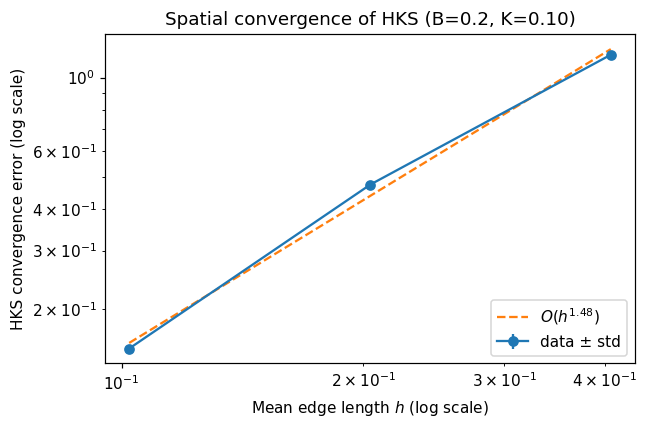

=== RQ1: 空间收敛性 ===
p ≈ 1.48, C ≈ 4.60e+00



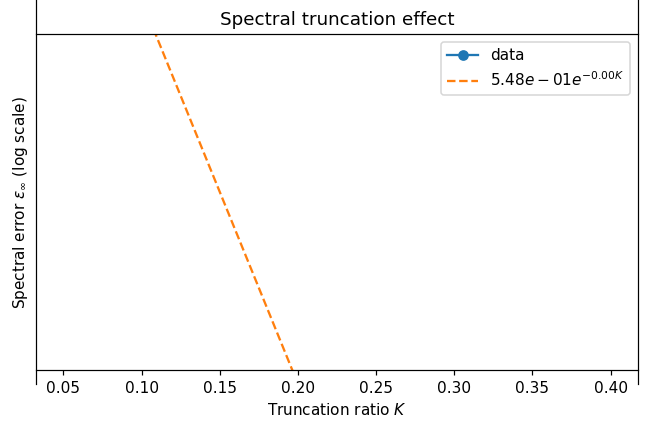

=== RQ2: 谱截断模型 ===
a = 5.48e-01, b = 0.00



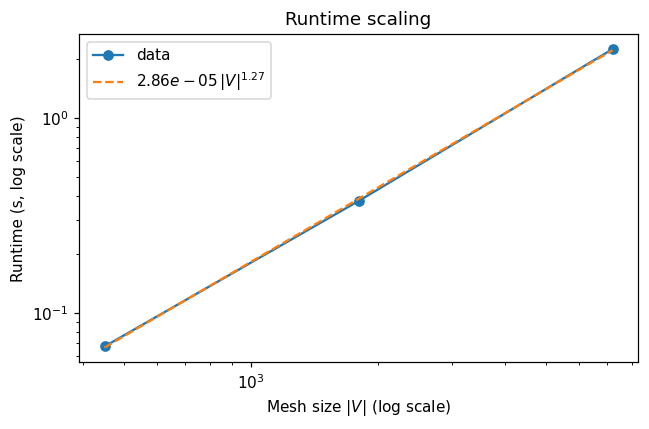

=== RQ3: 时间复杂度模型 ===
α = 2.86e-05, p_time = 1.27

=== RQ1: 多尺度曲率相关性 (K=0.05, B=0, analytic) ===
D=120x60: ρ = 0.119 ± 0.000, η = 0.0%
D=30x15: ρ = 0.233 ± 0.000, η = 2.0%
D=60x30: ρ = -0.165 ± 0.000, η = 0.7%


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 构建 DataFrame 并过滤 ===
df = pd.DataFrame(results, columns=[
    'D','K','C','B','rep',
    'err_rho','eta','eps_inf','err_conv',
    'time','h'
])
df = df[df.err_conv > 1e-16]

# === RQ1: 空间收敛性 (analytic, B=0.2, K=0.10) ===
sub_conv = df[(df.C == "analytic") & (df.B == 0.2) & (df.K == 0.10)]
g_conv = sub_conv.groupby('h')['err_conv'].agg(['mean', 'std']).reset_index()
p_conv, logC_conv = np.polyfit(np.log(g_conv['h']), np.log(g_conv['mean']), 1)
C_conv = np.exp(logC_conv)

plt.figure(figsize=(6,4))
plt.errorbar(
    g_conv['h'], g_conv['mean'], yerr=g_conv['std'],
    marker='o', linestyle='-', label='data ± std'
)
plt.plot(
    g_conv['h'], C_conv * g_conv['h']**p_conv,
    '--', label=f'$O(h^{{{p_conv:.2f}}})$'
)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Mean edge length $h$ (log scale)')
plt.ylabel('HKS convergence error (log scale)')
plt.title('Spatial convergence of HKS (B=0.2, K=0.10)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print(f"=== RQ1: 空间收敛性 ===\n"
      f"p ≈ {p_conv:.2f}, C ≈ {C_conv:.2e}\n")

# === RQ2: 谱截断误差模型 (D=60x30, B=0.2, analytic) ===
sub_spec = df[(df.D == "60x30") & (df.B == 0.2) & (df.C == "analytic")]
h_spec = sub_spec.groupby('K')['eps_inf'].mean().reset_index()
coef_spec = np.polyfit(h_spec['K'], np.log(h_spec['eps_inf']), 1)
b_spec, loga_spec = -coef_spec[0], coef_spec[1]
a_spec = np.exp(loga_spec)

plt.figure(figsize=(6,4))
plt.plot(h_spec['K'], h_spec['eps_inf'], 'o-', label='data')
plt.plot(
    h_spec['K'], a_spec * np.exp(-b_spec * h_spec['K']),
    '--', label=f'${a_spec:.2e}e^{{-{b_spec:.2f}K}}$'
)
plt.yscale('log')
plt.xlabel('Truncation ratio $K$')
plt.ylabel(r'Spectral error $\varepsilon_\infty$ (log scale)')
plt.title('Spectral truncation effect')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"=== RQ2: 谱截断模型 ===\n"
      f"a = {a_spec:.2e}, b = {b_spec:.2f}\n")

# === RQ3: 时间复杂度 (all data) ===
df['Vsize'] = df['D'].apply(lambda s: int(s.split('x')[0]) * int(s.split('x')[1]))
h_time = df.groupby('Vsize')['time'].mean().reset_index()
p_time, logalpha_time = np.polyfit(np.log(h_time['Vsize']), np.log(h_time['time']), 1)
alpha_time = np.exp(logalpha_time)

plt.figure(figsize=(6,4))
plt.plot(h_time['Vsize'], h_time['time'], 'o-', label='data')
plt.plot(
    h_time['Vsize'], alpha_time * h_time['Vsize']**p_time,
    '--', label=f'${alpha_time:.2e}\\,|V|^{{{p_time:.2f}}}$'
)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Mesh size $|V|$ (log scale)')
plt.ylabel('Runtime (s, log scale)')
plt.title('Runtime scaling')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

print(f"=== RQ3: 时间复杂度模型 ===\n"
      f"α = {alpha_time:.2e}, p_time = {p_time:.2f}\n")

# === 附加: RQ1 指标打印 (K=0.05, B=0, analytic) ===
print("=== RQ1: 多尺度曲率相关性 (K=0.05, B=0, analytic) ===")
df_rq1 = df[(df.K == 0.05) & (df.B == 0) & (df.C == "analytic")]
for D in sorted(df_rq1['D'].unique()):
    sub1 = df_rq1[df_rq1['D'] == D]
    rho_mean = 1 - sub1['err_rho'].mean()
    rho_std = sub1['err_rho'].std()
    eta_mean = sub1['eta'].mean()
    print(f"D={D}: ρ = {rho_mean:.3f} ± {rho_std:.3f}, η = {eta_mean:.1f}%")